In [2]:
%matplotlib inline
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize


In [3]:
def load_dataset(path: Path) -> pd.DataFrame:
    df = pd.read_json(path)
    df.date = pd.to_datetime(df.date, format="%Y-%m-%d %H:%M:%S")
    df.set_index('date', inplace=True)
    return df


In [4]:
df = load_dataset("../datasets/Hydra-L.json")
df.head()


,BME280_temp,BME280_humidity,BME280_pressure
date,,,
2022-07-06 00:00:04,30.45,34.93,746.19
2022-07-06 00:00:29,30.55,34.55,745.17
2022-07-06 00:00:30,28.27,43.74,746.70
2022-07-06 00:00:32,30.62,35.08,746.40
2022-07-06 00:00:33,27.05,45.82,746.68


In [5]:
def effective_temperature(t: np.ndarray, h: np.ndarray) -> np.ndarray:
    return t - 0.4 * (t - 10) * (1 - h / 100)


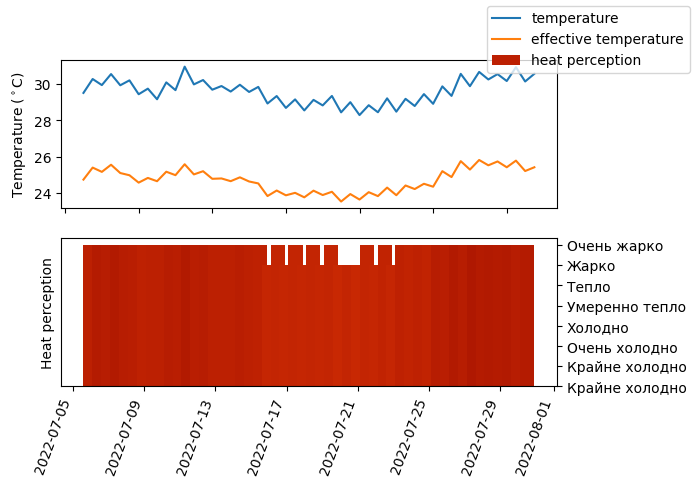

In [10]:
from bisect import bisect

HEAT_PERCEPTION = {
    -30: 'Крайне холодно',
    -24: 'Крайне холодно',
    -12: 'Очень холодно',
    0: 'Холодно',
    12: 'Умеренно тепло',
    18: 'Тепло',
    24: 'Жарко',
    30: 'Очень жарко',
}
_HP_VALUES = list(HEAT_PERCEPTION)
_HP_LABELS = list(HEAT_PERCEPTION.values())

def convert_labels(x: int) -> int:
    return bisect(_HP_VALUES, x)


def plot_effective(t: np.ndarray, h: np.ndarray) -> None:
    fig, (ax1, ax2) = plt.subplots(2, 1)
    fig.autofmt_xdate(rotation=70)

    eff = effective_temperature(t, h)

    ax1.plot(t, label='temperature')
    ax1.plot(eff, label='effective temperature')
    ax1.set_ylabel(r'Temperature ($^\circ$C)')


    x = [convert_labels(x) for x in eff]
    colormap = plt.get_cmap("turbo")
    rescale = Normalize(np.min(_HP_VALUES), np.max(_HP_VALUES))

    ax2.bar(eff.index, x, width=25 / len(x), label='heat perception', color=colormap(rescale(eff)))
    ax2.yaxis.tick_right()
    ax2.set_ylabel('Heat perception')
    ax2.set_yticks(ticks=np.arange(len(_HP_VALUES)), labels=_HP_LABELS)
    fig.legend()


df_mean = df.resample('12h').mean()
plot_effective(df_mean.BME280_temp, df_mean.BME280_humidity)
